<a href="https://colab.research.google.com/github/PilarAriasVazquez/Quantum-Machine-Learning/blob/main/VQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQC (Variatonal Quantum Circuits)

Main concepts:
-
- VQC: Quantum computing hybrid model that is design to work on actuals quantum computers (NISQ).
- Quantum Feature Map: Mathematical map that embeds classical data into a quantum state (qubits rotations)
- Ansatz: Basic Architecture of a circuit. Logic doors with  $\theta$ values to optimize
- Expectation Value: Measure with respect to the Z axis several times and we will return the value of the probability that it is 0 - the probability that it is 1 [P(0) - P(1)]. Equivalent to forward pass.
- Parameter Shift Rule: The quantums backpropagation.


Libraries:
- Pennylane: Open-source Python framework for quantum programming.
- Pytorch:  PyTorch is an open-source software-based deep learning framework used to create neural networks, combining the Torch machine learning (ML) library with a high-level Python-based API.

Essentially, a VQC is equivalent to a layer in a neural network, where neurons are replaced by qubit rotations. The weights and biases that are adjusted in classical deep learning are equivalent to adjusting the angles of quantum logic gates. There are three blocks:
1. Encoding -> A feature vector is passed to Hilbert space. Rotation gates are applied where the angle is equal to the value of the data. It has no trainable parameters.
2. Ansatz -> The parameters that are trained $\theta$. They are usually entangled using CNOT gates. Thus, thanks to this entanglement, qubits share information in a way that classical neurons cannot. Some of the positive aspects of this feature are based on finding non-local correlations, that is, representing extremely complex correlations. As well as problems with limited dimensionality, thanks to entanglement and superposition, while a classical system represents one of the 2^n possible states at a time, in a quantum system it is possible to explore those 2^n states simultaneously.
3. Measurement -> Collapses the quantum state into classical values. The expected value (usually between -1 and 1). This is the value expected by the standard loss function.



It is variational because, thanks to a classical optimizer, the parameters $\theta$ iterate until the loss is minimized; a complex quantum equation is not solved in one go. It is a hybrid loop:
1. Quantum hardware: Executes the circuit with parameters $\theta$ and measures the result.
2. Classical hardware: Receives the result, calculates the gradient, and updates $\theta$ for the next iteration.


In other words, VQCs are implicit kernel models, in which when the data passes through step 1 (encoding), it is projected to an infinite dimension in Hilbert space, and step 2 searches for the optimal hyperplane in that massive space to classify the data.


In [17]:
!pip install pennylane --upgrade -q

In [18]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.autograd import Variable

In [19]:
# Dispositivo
dev = qml.device("default.qubit", wires = 2)
# Circuito cuántico
@qml.qnode(dev, interface = "torch")
def quantum_net(weights, data):
  # Encoding
  qml.RY(data[0], wires = 0)
  qml.RY(data[1], wires = 1)
  # Ansatz -> Capa entrenable
  qml.RX(weights[0], wires = 0)
  qml.RX(weights[1], wires = 1)
  # Entrelazamiento
  qml.CNOT(wires = [0,1])
  # Medida
  return qml.expval(qml.PauliZ(0))

In [22]:
# Integración en el modelo Pytorch
class HybridModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # inicializamos 2 pesos aleatorios
    self.weights = torch.nn.Parameter(torch.rand(2))
  def forward(self, x):
    return quantum_net(self.weights, x)

model = HybridModel()
dummy_data = torch.tensor([0.5, -1.2])
prediction = model(dummy_data)
print(f"Predicción cuántica inicial: {prediction.item():.4f}")



Predicción cuántica inicial: 0.8513


# Training Loop



In [31]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [46]:
def plot_decision_boundary(model, X, y):
    # Create a grid of points
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                         np.linspace(y_min, y_max, 30))

    # Predict for each point on the grid
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        preds = torch.stack([model(p) for p in grid_points])
        preds = preds.reshape(xx.shape).numpy()

    # Plot the results
    plt.contourf(xx, yy, preds, cmap="RdBu", alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap="RdBu")
    plt.title("Quantum Decision Boundary")
    plt.xlabel("Sepal Length (normalized)")
    plt.ylabel("Sepal Width (normalized)")
    plt.show()

In [32]:
# Data
iris = load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]
y = y * 2 - 1 # so they match with `Pauli gate


In [33]:
# Pre process
scaler = MinMaxScaler(feature_range = (0, np.pi))
X = scaler.fit_transform(X)
X_train = torch.tensor(X, dtype = torch.float32)
y_train = torch.tensor(y, dtype = torch.float32)

# load model
model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
loss_fn = torch.nn.MSELoss()


In [40]:
# Training loop

epochs = 20

for epoch in range(epochs):
  optimizer.zero_grad() # Reset models params self.weights
  # Ensure all inputs to the model and loss function are of type torch.double
  # Cast X_train elements to double when passing to model
  # The output of model(x) will then be a double tensor, promoting consistency.
  predictions = torch.stack([model(x.double()) for x in X_train])

  # Cast y_train to double before computing loss
  loss = loss_fn(predictions, y_train.double())

  loss.backward()
  optimizer.step()
  if (epoch + 1) % 5 == 0:
    # For accuracy calculation, convert the boolean comparison result to float before taking the mean.
    acc = torch.mean(((predictions > 0) == (y_train.double() > 0)).float())
    # print(X_train.double(), y_train.double())
    print(f"Epoch {epoch+1:2d} | Loss: {loss.item():.4f} | Acc: {acc:.4f}")

Epoch  5 | Loss: 0.4980 | Acc: 0.8100
Epoch 10 | Loss: 0.4981 | Acc: 0.8100
Epoch 15 | Loss: 0.4980 | Acc: 0.8100
Epoch 20 | Loss: 0.4977 | Acc: 0.8100


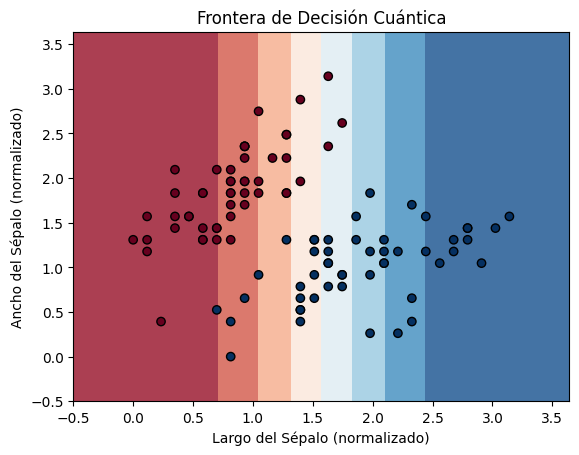

In [43]:
plot_decision_boundary(model, X_train, y_train)

## Add qubits + layers to see how the model gets better results

Data Re-uploading -> Insted of adding more qubits, we repeat encoding + ansatz.  

In [49]:

n_layers = 3
n_qubits = 2

@qml.qnode(dev, interface="torch")
def quantum_net(weights, data):
    # weights = (n_layers, n_qubits, 3)

    for i in range(n_layers):
        # 1. ENCODING
        for j in range(n_qubits):
            qml.RY(data[j], wires=j)

        # 2. ANSATZ
        for j in range(n_qubits):
            qml.Rot(*weights[i, j], wires=j) # Rotation (3 params: phi, theta, omega)

        # 3. ENTRELAZAMIENTO
        qml.CNOT(wires=[0, 1])

    return qml.expval(qml.PauliZ(0))

In [56]:
class DeepHybridModel(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()

        # weights: layers x qubits x 3 rotation params
        self.weights = torch.nn.Parameter(torch.randn(layers, n_qubits, 3))

    def forward(self, x):
        return quantum_net(self.weights, x)



In [57]:
# Data
iris = load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]
y = y * 2 - 1 # so they match with `Pauli gate


In [58]:
# Pre process
X = MinMaxScaler(feature_range = (0, np.pi)).fit_transform(X)
X_train = torch.tensor(X, dtype = torch.float32)
y_train = torch.tensor(y, dtype = torch.float32)

# load model

model = DeepHybridModel(layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = torch.nn.MSELoss()


In [59]:
# Training loop

epochs = 30

for epoch in range(epochs):
  optimizer.zero_grad() # Reset models params self.weights
  # Ensure all inputs to the model and loss function are of type torch.double
  # Cast X_train elements to double when passing to model
  # The output of model(x) will then be a double tensor, promoting consistency.
  predictions = torch.stack([model(x.double()) for x in X_train])

  # Cast y_train to double before computing loss
  loss = loss_fn(predictions, y_train.double())

  loss.backward()
  optimizer.step()
  if (epoch + 1) % 5 == 0:
    # For accuracy calculation, convert the boolean comparison result to float before taking the mean.
    acc = torch.mean(((predictions > 0) == (y_train.double() > 0)).float())

    print(f"Epoch {epoch+1:2d} | Loss: {loss.item():.4f} | Acc: {acc:.4f}")

Epoch  5 | Loss: 0.8374 | Acc: 0.7600
Epoch 10 | Loss: 0.5799 | Acc: 0.8200
Epoch 15 | Loss: 0.4153 | Acc: 0.8900
Epoch 20 | Loss: 0.2530 | Acc: 0.9800
Epoch 25 | Loss: 0.1888 | Acc: 0.9900
Epoch 30 | Loss: 0.1716 | Acc: 0.9800


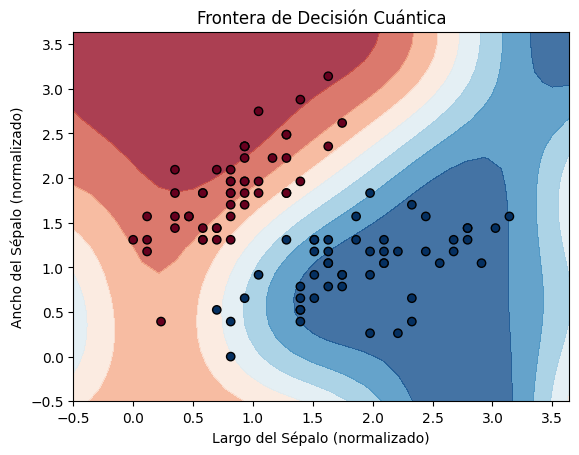

In [61]:
plot_decision_boundary(model, X_train, y_train)